In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import time
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
try:
    plt.rcParams['font.sans-serif'] = ['Heiti TC', 'Heiti SC', 'PingFang SC', 'SimHei', 'Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置此项以确保SVG中的字体是路径，从而实现可编辑性
    plt.rcParams['svg.fonttype'] = 'none' 
except Exception as e:
    print(f"注意：未能设置中文字体。图表中的中文可能无法正常显示。错误信息: {e}")


In [2]:
# =======================================================
# Cell 1: 转换、评估、对比
# =======================================================

# --- 1. 配置 ---
# 输入模型：你已经剪枝并微调好的16层FP32模型
PRUNED_FP32_MODEL_PATH = "./models/bert_pruned_16_layers_finetuned/best_model"

# 输出模型：我们将要创建并保存的FP16模型
PRUNED_FP16_MODEL_SAVE_PATH = "./models/bert_pruned_16L_fp16_gpu"

# 分词器名称
TOKENIZER_NAME = "bert-large-uncased"
# -----------------------------------------

TEST_SENTENCE = "This movie is not bad at all, in fact it is surprisingly good!"
LATENCY_RUNS = 100
EVAL_BATCH_SIZE = 32
FIGURE_DIR = "./figure" # 图表保存目录

# 确保GPU可用
if not torch.cuda.is_available():
    raise RuntimeError("This experiment requires a GPU!")
DEVICE = torch.device("cuda")

print("Configuration set. Using GPU for conversion and evaluation.")
os.makedirs(PRUNED_FP16_MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(FIGURE_DIR, exist_ok=True)

Configuration set. Using GPU for conversion and evaluation.


In [3]:
# --- 2. FP16模型转换与保存 ---
print(f"Loading FP32 model from: {PRUNED_FP32_MODEL_PATH}")
# 以FP16精度直接加载模型
model_fp16 = AutoModelForSequenceClassification.from_pretrained(
    PRUNED_FP32_MODEL_PATH,
    torch_dtype=torch.float16 # 关键：指定加载的数据类型为float16
).to(DEVICE)

# 加载对应的分词器
tokenizer = AutoTokenizer.from_pretrained(PRUNED_FP32_MODEL_PATH)

print(f"Saving FP16 model to: {PRUNED_FP16_MODEL_SAVE_PATH}")
model_fp16.save_pretrained(PRUNED_FP16_MODEL_SAVE_PATH)
tokenizer.save_pretrained(PRUNED_FP16_MODEL_SAVE_PATH)
print("FP16 model conversion and saving complete.")


# --- 3. 辅助函数 ---
def get_model_size(path):
    total_size = 0
    for dirpath, _, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size / (1024 * 1024)

def measure_latency(model, tokenizer, device):
    inputs = tokenizer(TEST_SENTENCE, return_tensors="pt").to(device)
    # 对于FP16模型，Hugging Face会自动处理输入类型，无需手动转换
    
    timings = []
    with torch.no_grad():
        for _ in range(20): # 预热
            _ = model(**inputs)
        
        for _ in range(LATENCY_RUNS):
            torch.cuda.synchronize()
            start_time = time.perf_counter()
            _ = model(**inputs)
            torch.cuda.synchronize()
            end_time = time.perf_counter()
            timings.append(end_time - start_time)
            
    return np.mean(timings) * 1000

def evaluate_accuracy(model, tokenizer, device, eval_dataloader):
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in tqdm(eval_dataloader, desc=f"Evaluating Accuracy"):
        # 确保只把模型需要的字段放到GPU
        batch = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'label']}
        # 将label字段重命名以匹配函数内部的引用
        batch['label'] = batch.pop('label')

        with torch.no_grad():
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        
        predictions = torch.argmax(outputs.logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["label"])
        
    return metric.compute()["accuracy"]

# --- 4. 数据准备 ---
print("Preparing dataset for evaluation...")
raw_datasets = load_dataset("glue", "sst2")
tokenizer_for_map = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
def tokenize_function(examples):
    return tokenizer_for_map(examples["sentence"], padding="max_length", truncation=True, max_length=128)
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
# 移除不需要的列，以避免在collate时产生警告
tokenized_datasets = tokenized_datasets.remove_columns(['sentence', 'idx'])
tokenized_datasets.set_format('torch')
eval_dataset = tokenized_datasets["validation"]
eval_dataloader = DataLoader(eval_dataset, batch_size=EVAL_BATCH_SIZE)
print("Dataset ready.")


# --- 5. 性能对比评估 ---
results = []
models_to_compare = [
    # --- 修改点：更新模型名称和描述 ---
    {"name": "Pruned FP32 (16L)", "path": PRUNED_FP32_MODEL_PATH, "dtype": torch.float32},
    {"name": "Pruned FP16 (16L)", "path": PRUNED_FP16_MODEL_SAVE_PATH, "dtype": torch.float16}
]

for config in models_to_compare:
    print(f"\n{'='*20} EVALUATING: {config['name']} {'='*20}")
    current_results = {"Model": config['name']}
    
    current_results["Size (MB)"] = get_model_size(config['path'])
    
    model = AutoModelForSequenceClassification.from_pretrained(config['path'], torch_dtype=config['dtype']).to(DEVICE)
    tokenizer = AutoTokenizer.from_pretrained(config['path'])
    
    torch.cuda.reset_peak_memory_stats(DEVICE)
    inputs_for_mem = tokenizer(TEST_SENTENCE, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        _ = model(**inputs_for_mem)
    peak_mem_mb = torch.cuda.max_memory_allocated(DEVICE) / (1024 * 1024)
    current_results["Peak GPU Mem (MB)"] = peak_mem_mb
    
    current_results["Latency (GPU, ms)"] = measure_latency(model, tokenizer, DEVICE)
    current_results["Accuracy (GPU)"] = evaluate_accuracy(model, tokenizer, DEVICE, eval_dataloader)
    
    results.append(current_results)
    del model
    torch.cuda.empty_cache()

# 展示对比结果
print(f"\n{'='*25} FINAL RESULTS {'='*25}")
df = pd.DataFrame(results)
# 格式化
for col in ["Size (MB)", "Peak GPU Mem (MB)", "Latency (GPU, ms)"]:
    df[col] = df[col].map('{:.2f}'.format)
df["Accuracy (GPU)"] = df["Accuracy (GPU)"].map('{:.4f}'.format)

print(df.to_markdown(index=False))

Loading FP32 model from: ./models/bert_pruned_16_layers_finetuned/best_model
Saving FP16 model to: ./models/bert_pruned_16L_fp16_gpu
FP16 model conversion and saving complete.
Preparing dataset for evaluation...
Dataset ready.

==================== EVALUATING: Pruned FP32 (16L) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


==================== EVALUATING: Pruned FP16 (16L) ====================


Evaluating Accuracy:   0%|          | 0/28 [00:00<?, ?it/s]


========================= FINAL RESULTS =========================
| Model             |   Size (MB) |   Peak GPU Mem (MB) |   Latency (GPU, ms) |   Accuracy (GPU) |
|:------------------|------------:|--------------------:|--------------------:|-----------------:|
| Pruned FP32 (16L) |      895    |             1351.93 |                4.11 |           0.9392 |
| Pruned FP16 (16L) |      447.97 |              904.25 |                4.11 |           0.9392 |



--- Testing with Batch Size: 1 ---
FP32 Latency: 4.04 ms
FP16 Latency: 4.11 ms

--- Testing with Batch Size: 2 ---
FP32 Latency: 4.11 ms
FP16 Latency: 4.12 ms

--- Testing with Batch Size: 4 ---
FP32 Latency: 4.36 ms
FP16 Latency: 4.22 ms

--- Testing with Batch Size: 8 ---
FP32 Latency: 4.48 ms
FP16 Latency: 4.14 ms

--- Testing with Batch Size: 16 ---
FP32 Latency: 7.10 ms
FP16 Latency: 4.15 ms

--- Testing with Batch Size: 32 ---
FP32 Latency: 9.08 ms
FP16 Latency: 3.97 ms

--- Testing with Batch Size: 64 ---
FP32 Latency: 12.18 ms


findfont: Generic family 'sans-serif' not found because none of the following families were found: Heiti TC, Heiti SC, PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Heiti TC, Heiti SC, PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Heiti TC, Heiti SC, PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Heiti TC, Heiti SC, PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Heiti TC, Heiti SC, PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because none of the following families were found: Heiti TC, Heiti SC, PingFang SC, SimHei, Arial Unicode MS
findfont: Generic family 'sans-serif' not found because no

FP16 Latency: 4.03 ms

--- Latency Comparison Table ---
|   Batch Size |   FP32 Latency (ms) |   FP16 Latency (ms) |
|-------------:|--------------------:|--------------------:|
|            1 |             4.0396  |             4.11106 |
|            2 |             4.10503 |             4.11568 |
|            4 |             4.35713 |             4.22455 |
|            8 |             4.48344 |             4.14341 |
|           16 |             7.10274 |             4.1457  |
|           32 |             9.07528 |             3.9675  |
|           64 |            12.1825  |             4.03191 |
图表已保存为可编辑的SVG文件: figure/large_fp32_vs_fp16_latency_batches.svg


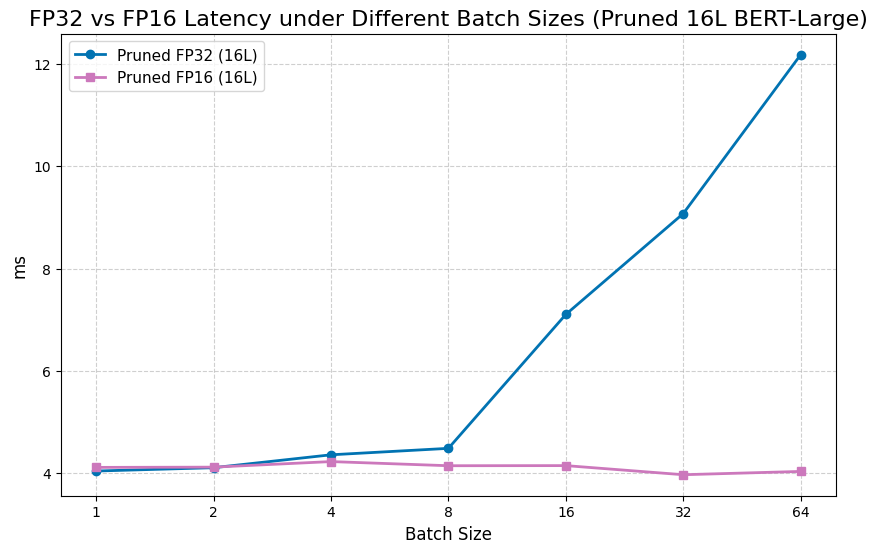

In [4]:
# =======================================================
# Cell 2: 不同批量大小下的延迟对比
# =======================================================

# --- 配置 ---
FP32_PATH = PRUNED_FP32_MODEL_PATH
FP16_PATH = PRUNED_FP16_MODEL_SAVE_PATH
TOKENIZER_PATH = PRUNED_FP16_MODEL_SAVE_PATH # Tokenizer和FP16模型保存在一起
# ------------------------------------

BATCH_SIZES = [1, 2, 4, 8, 16, 32, 64]
WARMUP_RUNS = 20
LATENCY_RUNS = 100

# --- 加载分词器和准备测试数据 ---
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
test_sentences = [TEST_SENTENCE] * max(BATCH_SIZES)

# --- 加载模型 ---
model_fp32 = AutoModelForSequenceClassification.from_pretrained(FP32_PATH, torch_dtype=torch.float32).to(DEVICE).eval()
model_fp16 = AutoModelForSequenceClassification.from_pretrained(FP16_PATH, torch_dtype=torch.float16).to(DEVICE).eval()

latency_results = []

# --- 循环测试 ---
for bs in BATCH_SIZES:
    print(f"\n--- Testing with Batch Size: {bs} ---")
    inputs = tokenizer(test_sentences[:bs], return_tensors="pt", padding=True).to(DEVICE)
    
    # 测试 FP32
    fp32_timings = []
    with torch.no_grad():
        for _ in range(WARMUP_RUNS): _ = model_fp32(**inputs)
        for _ in range(LATENCY_RUNS):
            torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model_fp32(**inputs)
            torch.cuda.synchronize()
            end = time.perf_counter()
            fp32_timings.append(end - start)
    fp32_latency = np.mean(fp32_timings) * 1000
    print(f"FP32 Latency: {fp32_latency:.2f} ms")

    # 测试 FP16
    fp16_timings = []
    with torch.no_grad():
        for _ in range(WARMUP_RUNS): _ = model_fp16(**inputs)
        for _ in range(LATENCY_RUNS):
            torch.cuda.synchronize()
            start = time.perf_counter()
            _ = model_fp16(**inputs)
            torch.cuda.synchronize()
            end = time.perf_counter()
            fp16_timings.append(end - start)
    fp16_latency = np.mean(fp16_timings) * 1000
    print(f"FP16 Latency: {fp16_latency:.2f} ms")
    
    latency_results.append({
        "Batch Size": bs,
        "FP32 Latency (ms)": fp32_latency,
        "FP16 Latency (ms)": fp16_latency
    })

# --- 可视化结果 ---
df_latency = pd.DataFrame(latency_results)
print("\n--- Latency Comparison Table ---")
print(df_latency.to_markdown(index=False))

fp32_color = '#0173B2'
fp16_color = '#CC78BC'

plt.figure(figsize=(10, 6))

plt.plot(df_latency["Batch Size"], df_latency["FP32 Latency (ms)"], marker='o', label="Pruned FP32 (16L)", color=fp32_color, linewidth=2)
plt.plot(df_latency["Batch Size"], df_latency["FP16 Latency (ms)"], marker='s', label="Pruned FP16 (16L)", color=fp16_color, linewidth=2)

plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("ms", fontsize=12)
plt.title("FP32 vs FP16 Latency under Different Batch Sizes (Pruned 16L BERT-Large)", fontsize=16)

plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xscale('log', base=2) # X轴使用以2为底的对数坐标
plt.xticks(df_latency["Batch Size"], df_latency["Batch Size"]) # 确保X轴刻度清晰显示

output_dir = 'figure'
output_filename = 'large_fp32_vs_fp16_latency_batches.svg'

# 检查目录是否存在，不存在则创建
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存为透明背景的SVG文件，bbox_inches='tight'确保所有元素都被完整保存
plt.savefig(os.path.join(output_dir, output_filename), format='svg', bbox_inches='tight', transparent=True)
print(f"图表已保存为可编辑的SVG文件: {os.path.join(output_dir, output_filename)}")

# 显示图表
plt.show()
